In [33]:
# @title # AI Weather Predictor for Georgia (GFS & ConvLSTM combo)
# @markdown Code made by Joshua Green
# @markdown ---
# @markdown **Here's the general concept:**
# @markdown 1.  **Setup Environment**: Install and import all necessary libraries.
# @markdown 2.  **Download Data**: Fetch historical weather forecast data directly from the **NOAA NOMADS** server. We are using the GFS (Global Forecast System) 0.25-degree dataset.
# @markdown 3.  **Process and Prepare Data**: Load the data, select variables (temperature and wind), normalize them for the AI, and create sequences for training.
# @markdown 4.  **Build the AI Model**: Construct a **Convolutional LSTM (ConvLSTM)** model, since this is a spatial data probelem
# @markdown 5.  **Train the Model**: Train the AI on the historical data.
# @markdown 6.  **Generate & Visualize Forecast**: Use the trained model to predict the next 48 hours of weather and create an animated map of the forecast.



In [34]:
# @title ## 1. Setup Environment
# @markdown This cell installs and imports the required Python libraries.
# @markdown - `xarray` & `cfgrib`: For reading GRIB2 weather data files {all-time worst file format}.
# @markdown - `tensorflow`: For building and training the AI model.
# @markdown - `cartopy`: For creating maps and geographic visualizations.
# @markdown - `requests`: For downloading data from NOAA and likewise.


# --- 1. Install System-Level Dependency (eccodes) ---
!apt-get -qq update && apt-get -qq install -y libeccodes-dev

# --- 2. Install Python Libraries ---
!pip install xarray cfgrib tensorflow requests cartopy

# --- 3. Core Imports ---
import os
import requests
from datetime import datetime, timedelta, timezone

# --- Data Handling ---
import xarray as xr
import numpy as np

# --- ML Imports ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv2D

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import cartopy.crs as ccrs
import cartopy.feature as cfeature

print("\nLibraries installed successfully.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

✅ Libraries installed successfully.


In [35]:
# @title ## 2. Configuration & Data Download (

# --- Imports for this cell (this code sometimes breaks without these) ---
import os
import requests
from datetime import datetime, timedelta, timezone

# --- Configuration ---
# Bounding box for Georgia [West, East, South, North]
GEORGIA_BBOX = [-85.8, -80.8, 30.3, 35.1]

# How many past days of GFS runs to download for training
DAYS_TO_DOWNLOAD = 30
# Each GFS run is 6 hours apart (00Z, 06Z, 12Z, 18Z)
RUNS_PER_DAY = 4
TOTAL_RUNS = DAYS_TO_DOWNLOAD * RUNS_PER_DAY

# Use 12 hours of data to predict the next hour
SEQUENCE_LENGTH = 12

# Create a directory to store the downloaded data
DATA_DIR = "gfs_data"
os.makedirs(DATA_DIR, exist_ok=True)

def find_latest_gfs_run_time():
    """
    Calculates the most recent GFS model run time that is likely available on the server.
    GFS runs take several hours to be fully published.
    """
    now_utc = datetime.now(timezone.utc)
    # To be safe, look back 5 hours to ensure the data is fully available.
    search_time = now_utc - timedelta(hours=5)
    # Round down to the nearest 6-hour GFS cycle (00, 06, 12, 18).
    run_hour = (search_time.hour // 6) * 6
    latest_run_time = search_time.replace(hour=run_hour, minute=0, second=0, microsecond=0)
    return latest_run_time

def download_gfs_data():
    """
    Downloads GFS data from the NOAA NOMADS server with corrected logic.
    """
    print(f"--- Starting GFS Data Download for the last {TOTAL_RUNS} runs ---")
    base_url = "https://nomads.ncep.noaa.gov/pub/data/nccf/com/gfs/prod/"

    # Find the latest available run and create a list of past runs to download
    latest_run = find_latest_gfs_run_time()
    run_times_to_download = [latest_run - timedelta(hours=i * 6) for i in range(TOTAL_RUNS)]

    downloaded_files = []

    # This header makes the script look like a browser, preventing 403 Forbidden errors.
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    for run_time in run_times_to_download:
        date_str = run_time.strftime("gfs.%Y%m%d")
        hour_str = run_time.strftime("%H")

        # First forecast hour (f000) which is the "analysis" step
        file_name = f"gfs.t{hour_str}z.pgrb2.0p25.f000"
        full_url = f"{base_url}{date_str}/{hour_str}/atmos/{file_name}"
        local_path = os.path.join(DATA_DIR, f"{date_str}_{hour_str}.grib2")

        if os.path.exists(local_path):
            print(f"File already exists: {local_path}")
            downloaded_files.append(local_path)
            continue

        try:
            print(f"⬇Downloading: {full_url}")
            with requests.get(full_url, stream=True, headers=headers) as r:
                r.raise_for_status() # This will activate if error for bad status codes (like 403, 404)
                with open(local_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"Saved to: {local_path}")
            downloaded_files.append(local_path)
        except requests.exceptions.HTTPError as e:
            print(f"Failed to download {full_url}. Reason: {e}. Maybe data for this run is not available yet.")
        except Exception as e:
            print(f"An unexpected error occurred: {e}")

    # Return the list of files in chronological order
    return sorted(downloaded_files)

# --- Execute Download ---
grib_files = download_gfs_data()
if not grib_files:
    print("\nCRITICAL: No data was downloaded. Cannot proceed.")
else:
    print(f"\nSuccessfully downloaded {len(grib_files)} GFS runs.")

--- Starting GFS Data Download for the last 20 runs ---
☑️ File already exists: gfs_data/gfs.20251001_12.grib2
☑️ File already exists: gfs_data/gfs.20251001_06.grib2
☑️ File already exists: gfs_data/gfs.20251001_00.grib2
☑️ File already exists: gfs_data/gfs.20250930_18.grib2
☑️ File already exists: gfs_data/gfs.20250930_12.grib2
☑️ File already exists: gfs_data/gfs.20250930_06.grib2
☑️ File already exists: gfs_data/gfs.20250930_00.grib2
☑️ File already exists: gfs_data/gfs.20250929_18.grib2
☑️ File already exists: gfs_data/gfs.20250929_12.grib2
☑️ File already exists: gfs_data/gfs.20250929_06.grib2
☑️ File already exists: gfs_data/gfs.20250929_00.grib2
☑️ File already exists: gfs_data/gfs.20250928_18.grib2
☑️ File already exists: gfs_data/gfs.20250928_12.grib2
☑️ File already exists: gfs_data/gfs.20250928_06.grib2
☑️ File already exists: gfs_data/gfs.20250928_00.grib2
☑️ File already exists: gfs_data/gfs.20250927_18.grib2
☑️ File already exists: gfs_data/gfs.20250927_12.grib2
☑️ File a

In [36]:
# @title ## 3. Process and Prepare Data
def load_and_process_data(file_list):
    """
    Loads GRIB files, selects variables, and normalizes them.
    """
    if not file_list:
        return None, None, None, None

    datasets = []
    print("\n--- Loading and Processing GRIB Files ---")
    for f in file_list:
        try:
            # --- Open the file just for the 2-meter temperature ('t2m') ---
            ds_temp = xr.open_dataset(f, engine="cfgrib", backend_kwargs={
                'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 2}
            })

            # --- Open the same file again, but just for 10-meter wind ('u10', 'v10') ---
            # The code will not work if you try and load both at the same time
            ds_wind = xr.open_dataset(f, engine="cfgrib", backend_kwargs={
                'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 10}
            })

            # Select and clip each variable to the Georgia bounding box
            # Note: GFS longitude is on a 0-360 scale, so adjust -85.8 longitude selection.
            temp = ds_temp['t2m'].sel(latitude=slice(GEORGIA_BBOX[3], GEORGIA_BBOX[2]),
                                     longitude=slice(GEORGIA_BBOX[0] + 360, GEORGIA_BBOX[1] + 360))
            u_wind = ds_wind['u10'].sel(latitude=slice(GEORGIA_BBOX[3], GEORGIA_BBOX[2]),
                                       longitude=slice(GEORGIA_BBOX[0] + 360, GEORGIA_BBOX[1] + 360))
            v_wind = ds_wind['v10'].sel(latitude=slice(GEORGIA_BBOX[3], GEORGIA_BBOX[2]),
                                       longitude=slice(GEORGIA_BBOX[0] + 360, GEORGIA_BBOX[1] + 360))

            # Stack variables into a single DataArray and convert to a NumPy array
            combined = xr.concat([temp, u_wind, v_wind], dim='variable').to_numpy()
            datasets.append(combined)

            # Close datasets to free up resources
            ds_temp.close()
            ds_wind.close()

        except Exception as e:
            print(f"Could not process file {f}. Skipping. Reason: {e}")

    if not datasets:
        print("No datasets could be processed.")
        return None, None, None, None

    # Stack all time steps
    full_data = np.stack(datasets, axis=0)
    print(f"Data shape (time, variables, lat, lon): {full_data.shape}")

    # Normalize data (important for neural networks)
    data_min = full_data.min(axis=(0, 2, 3), keepdims=True)
    data_max = full_data.max(axis=(0, 2, 3), keepdims=True)
    normalized_data = (full_data - data_min) / (data_max - data_min)

    # Transpose to (time, lat, lon, variables) for ConvLSTM model input shape
    normalized_data = np.transpose(normalized_data, (0, 2, 3, 1))
    print(f"Final normalized data shape for model: {normalized_data.shape}")

    return normalized_data, data_min, data_max, temp.coords

# --- Execute Processing ---
if 'grib_files' in locals() and grib_files:
    data, data_min, data_max, coords = load_and_process_data(grib_files)
else:
    print("GRIB files not found. Please run the download cell first.")
    data, data_min, data_max, coords = None, None, None, None


def create_sequences(data, n_past):
    """
    Creates input/output sequences for the time-series model.
    """
    X, y = [], []
    if data is None or len(data) <= n_past:
        return np.array(X), np.array(y)

    for i in range(len(data) - n_past):
        X.append(data[i : i + n_past])
        y.append(data[i + n_past])
    return np.array(X), np.array(y)


# --- Create Sequences for Training ---
if data is not None:
    X_train, y_train = create_sequences(data, SEQUENCE_LENGTH)
    if X_train.shape[0] > 0:
        print(f"\nCreated training sequences.")
        print(f"X_train shape: {X_train.shape}") # (samples, time_steps, lat, lon, variables)
        print(f"y_train shape: {y_train.shape}")   # (samples, lat, lon, variables)
    else:
        print("\nNot enough data to create training sequences. Please download more days of data.")
else:
    X_train, y_train = np.array([]), np.array([])


--- Loading and Processing GRIB Files ---
Data shape (time, variables, lat, lon): (20, 3, 19, 20)
Final normalized data shape for model: (20, 19, 20, 3)

✅ Created training sequences.
X_train shape: (8, 12, 19, 20, 3)
y_train shape: (8, 19, 20, 3)


In [37]:
# @title ## 4. Build the ConvLSTM AI Model

def build_convlstm_model(input_shape):
    """
    Builds and compiles the ConvLSTM model.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Encoder part
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu'))
    model.add(BatchNormalization())
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=False, activation='relu'))
    model.add(BatchNormalization())

    # Decoder part - predicts the next frame
    # The output has 3 channels: Temp, U-wind, V-wind
    model.add(Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer='adam', loss='mse')
    print("Model built successfully.")
    model.summary()
    return model

# --- Build the model ---
if X_train.shape[0] > 0:
    model_input_shape = X_train.shape[1:]
    model = build_convlstm_model(model_input_shape)
else:
    print("Cannot build model without training data.")
    model = None

✅ Model built successfully.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 12, 19, 20, 32) │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 19, 20, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 19, 20, 64)     │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 19, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 20, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,003 (1.01 MB)

 Trainable params: 263,811 (1.01 MB)

 Non-trainable params: 192 (768.00 B)


--- Starting Model Training ---
Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.0492 - val_loss: 0.0213
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - loss: 0.0244 - val_loss: 0.0220
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - loss: 0.0129 - val_loss: 0.0228
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0129 - val_loss: 0.0242
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 466ms/step - loss: 0.0134 - val_loss: 0.0258
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - loss: 0.0090 - val_loss: 0.0262
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.0148 - val_loss: 0.0280
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 638ms/step - loss: 0.0099 - val_loss: 0.0294
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.0140 - val_loss: 0.0307
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 570ms/step - loss: 0.0142 - val_loss: 0.0317
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - loss: 0.0080 - val_loss: 0.0328
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━

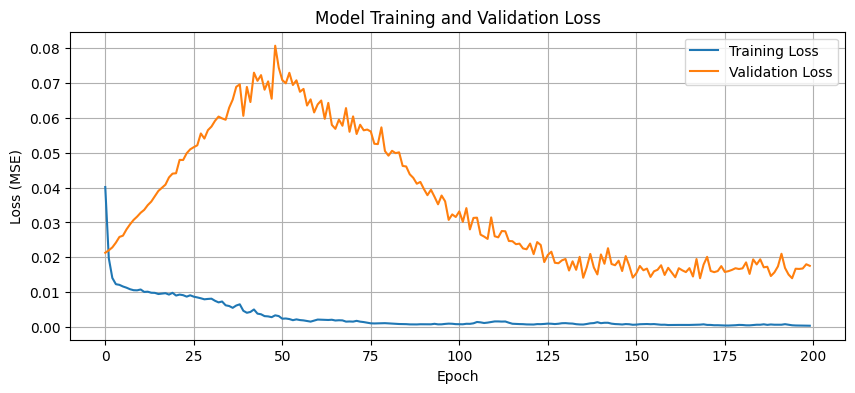

In [38]:
# @title ## 5. Train the Model

if model and X_train.shape[0] > 0:
    print("\n--- Starting Model Training ---")
    history = model.fit(
        X_train, y_train,
        batch_size=0.2,
        epochs=100, # Increase epochs for better results on a larger dataset
        validation_split=0.2,
        verbose=1
    )
    print("\nModel training complete.")

    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping training because model or data is not available.")

In [39]:
# @title ## 6. Generate and Visualize 48-Hour Forecast
# @markdown The exciting part! And also the really hard part. We use the trained model to predict the weather for the
# @markdown next 48 hours. The prediction is done autoregressively:
# @markdown 1. Predict hour `t+1` from the last known `N` hours.
# @markdown 2. Use the prediction for `t+1` as input to predict `t+2`.
# @markdown 3. Repeat 48 times.
# @markdown Finally, create an animated map of the forecast.

def generate_forecast(model, initial_sequence, steps):
    """
    Generates a forecast for a given number of future steps.
    """
    if model is None or initial_sequence.size == 0:
        return None
    print(f"\n--- Generating {steps}-hour forecast ---")
    forecast = []
    current_sequence = np.expand_dims(initial_sequence, axis=0)

    for i in range(steps):
        # Predict the next step
        next_step = model.predict(current_sequence, verbose=0)

        # Append the prediction to the forecast list
        forecast.append(next_step[0])

        # Update the sequence for the next prediction
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1, :, :, :] = next_step

        print(f" forecasting step {i+1}/{steps}", end='\r')

    return np.array(forecast)


def denormalize_data(normalized_data, data_min, data_max):
    """
    Converts normalized data back to its original scale.
    """
    # The shape of min/max is (1, 3, 1, 1), but data is (steps, lat, lon, 3)
    # Align the shapes for broadcasting
    min_vals = data_min.reshape(1, 1, 1, 3)
    max_vals = data_max.reshape(1, 1, 1, 3)
    return normalized_data * (max_vals - min_vals) + min_vals

# --- Generate the Forecast ---
if model and X_train.shape[0] > 0:
    # Use the last available sequence from our data as the starting point
    initial_seed = data[-SEQUENCE_LENGTH:]
    forecast_normalized = generate_forecast(model, initial_seed, steps=48)

    # Convert the forecast back to original units (Kelvin, m/s)
    forecast_denormalized = denormalize_data(forecast_normalized, data_min, data_max)

    print("\nForecast generation complete.")
    print(f"Forecast shape: {forecast_denormalized.shape}") # (steps, lat, lon, variables)
else:
    forecast_denormalized = None
    print("Skipping forecast generation.")


# --- Animate the Forecast ---
if forecast_denormalized is not None:
    print("\n--- Creating Forecast Animation ---")
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    lats = coords['latitude']
    lons = coords['longitude'] - 360 # Convert back to -180 to 180

    def update(frame):
        ax.clear()
        ax.set_extent([GEORGIA_BBOX[0], GEORGIA_BBOX[1], GEORGIA_BBOX[2], GEORGIA_BBOX[3]], crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.STATES, linestyle=':')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Temperature data (Kelvin to Celsius)
        temp_data = forecast_denormalized[frame, :, :, 0] - 273.15
        # Wind data
        u_wind = forecast_denormalized[frame, :, :, 1]
        v_wind = forecast_denormalized[frame, :, :, 2]
        wind_speed = np.sqrt(u_wind**2 + v_wind**2)

        # Plot Temperature as filled contours
        contour = ax.contourf(lons, lats, temp_data, cmap='coolwarm', levels=np.linspace(0, 35, 20), transform=ccrs.PlateCarree())
        if frame == 0:
            cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
            cbar.set_label('Temperature (°C)')

        # Plot wind vectors (quiver) - subsample for clarity
        subsample = 5
        ax.quiver(lons[::subsample], lats[::subsample], u_wind[::subsample, ::subsample], v_wind[::subsample, ::subsample],
                    transform=ccrs.PlateCarree(), scale=200, color='black')

        ax.set_title(f'ConvLSTM Forecast for Georgia\nForecast Hour: +{frame + 1} Hours')
        return ax

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=forecast_denormalized.shape[0], blit=False, repeat=False)
    plt.close() # Prevents static plot from displaying

    # Display the animation in Colab
    display(HTML(ani.to_jshtml()))
else:
    print("Cannot create animation without forecast data.")


--- Generating 48-hour forecast ---
 forecasting step 48/48
✅ Forecast generation complete.
Forecast shape: (48, 19, 20, 3)

--- Creating Forecast Animation ---


/tmp/ipython-input-1440323148.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)
/tmp/ipython-input-1440323148.py:87: UserWarning: Adding colorbar to a different Figure <Figure size 1200x800 with 3 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.02, shrink=0.8)


<Figure size 640x480 with 0 Axes>

In [45]:
# @title ## 7. AdaBoost-ConvLSTM Ensemble
# @markdown Here, I implement the AdaBoost.R2 algorithm with simple ConvLSTM models
# @markdown as the "weak learners". (This model came to me late in the night, hence it's very late placement)

def build_weak_learner(input_shape):
    """
    Defines a very simple ConvLSTM model to act as the weak learner in our ensemble.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    # A single ConvLSTM layer is enough for a weak learner
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False, activation='relu'))
    model.add(BatchNormalization())
    # The final Conv2D layer to predict the 3 output variables
    model.add(Conv2D(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))
    model.compile(optimizer='adam', loss='mse')
    return model

# --- AdaBoost Training Loop ---
if X_train.shape[0] > 0:
    n_estimators = 10  # Number of weak models to train in sequence
    n_samples = X_train.shape[0]

    # Initialize sample weights uniformly
    sample_weights = np.full(n_samples, 1 / n_samples)

    estimators = []
    estimator_weights = []

    print(f"--- Building AdaBoost Ensemble with {n_estimators} Estimators ---")

    for i in range(n_estimators):
        print(f"\n--- Training Estimator {i+1}/{n_estimators} ---")

        # 1. Resample data based on weights
        # Select training samples with replacement, biased by their weights
        resample_indices = np.random.choice(n_samples, n_samples, replace=True, p=sample_weights)
        X_resampled, y_resampled = X_train[resample_indices], y_train[resample_indices]

        # 2. Train a weak learner on the resampled data
        weak_model = build_weak_learner(X_train.shape[1:])
        weak_model.fit(X_resampled, y_resampled, epochs=100, batch_size=1, verbose=0)

        # 3. Calculate error on the original data
        predictions = weak_model.predict(X_train, verbose=0)
        # Calculate pixel-wise squared error for each sample
        errors = np.mean((y_train - predictions)**2, axis=(1, 2, 3))

        # Prevent division by zero if an error is 0
        max_error = np.max(errors)
        if max_error == 0:
            print("Skipping estimator due to zero error.")
            continue

        normalized_errors = errors / max_error

        # 4. Calculate estimator weight (beta)
        avg_error = np.sum(sample_weights * normalized_errors)
        if avg_error >= 0.5: # If the model is worse than random, stop.
            print("Terminating early: Estimator is not better than random.")
            break

        beta = avg_error / (1 - avg_error)

        # 5. Update sample weights
        # Use beta to decrease the weight of easy samples and increase the weight of hard ones
        sample_weights *= np.power(beta, (1 - normalized_errors))
        sample_weights /= np.sum(sample_weights) # Normalize to sum to 1

        estimators.append(weak_model)
        estimator_weights.append(np.log(1 / beta)) # Alpha (final prediction weight) is log(1/beta)

    print("\nAdaBoost Ensemble training complete.")
else:
    estimators = []
    print("Skipping AdaBoost training because data is not available.")

--- Building AdaBoost Ensemble with 10 Estimators ---

--- Training Estimator 1/10 ---
Terminating early: Estimator is not better than random.

AdaBoost Ensemble training complete.


In [46]:
# @title ## 8. Generate and Visualize AdaBoost-ConvLSTM Forecast
# @markdown Now, we'll generate a forecast using our ensemble and create a new animation.
# @markdown The final prediction is a weighted median of all weak models' outputs.

def adaboost_predict(models, model_weights, initial_sequence, steps):
    """
    Generates a forecast using the weighted predictions of the ensemble.
    """
    if not models:
        return None

    print(f"\n--- Generating {steps}-hour AdaBoost forecast ---")

    forecast_sequences = [np.expand_dims(initial_sequence, axis=0) for _ in models]
    final_forecast = []

    for step in range(steps):
        step_predictions = []
        # Get a prediction from each model for the current step
        for i, model in enumerate(models):
            pred = model.predict(forecast_sequences[i], verbose=0)
            step_predictions.append(pred[0])

        # Calculate the weighted median for the step prediction
        # Sorting is necessary for the weighted median calculation
        step_predictions = np.array(step_predictions)
        sorted_indices = np.argsort(step_predictions, axis=0)

        # Create sorted arrays for predictions and weights
        sorted_preds = np.take_along_axis(step_predictions, sorted_indices, axis=0)
        sorted_weights = np.array(model_weights)[sorted_indices.T].T # Sort weights to match predictions

        # Find the median
        cumsum_weights = np.cumsum(sorted_weights, axis=0)
        median_indices = np.argmax(cumsum_weights >= 0.5 * np.sum(model_weights), axis=0)

        weighted_median = np.choose(median_indices, sorted_preds)
        final_forecast.append(weighted_median)

        # Update the input sequence for the next step for all models
        for i in range(len(models)):
            forecast_sequences[i] = np.roll(forecast_sequences[i], -1, axis=1)
            forecast_sequences[i][0, -1, :, :, :] = weighted_median

        print(f" forecasting step {step+1}/{steps}", end='\r')

    return np.array(final_forecast)

# --- Generate the Forecast ---
if 'estimators' in locals() and estimators:
    initial_seed = data[-SEQUENCE_LENGTH:]
    forecast_normalized_ada = adaboost_predict(estimators, estimator_weights, initial_seed, steps=48)
    forecast_denormalized_ada = denormalize_data(forecast_normalized_ada, data_min, data_max)
    print("\nAdaBoost forecast generation complete.")
else:
    forecast_denormalized_ada = None
    print("Skipping AdaBoost forecast generation.")

# --- Animate the AdaBoost Forecast ---
if forecast_denormalized_ada is not None:
    print("\n--- Creating AdaBoost Forecast Animation ---")
    fig_ada = plt.figure(figsize=(12, 8))
    ax_ada = fig_ada.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    lats = coords['latitude']
    lons = coords['longitude'] - 360

    def update_ada(frame):
        ax_ada.clear()
        ax_ada.set_extent([GEORGIA_BBOX[0], GEORGIA_BBOX[1], GEORGIA_BBOX[2], GEORGIA_BBOX[3]], crs=ccrs.PlateCarree())
        ax_ada.add_feature(cfeature.STATES, linestyle=':')
        ax_ada.add_feature(cfeature.COASTLINE)
        ax_ada.add_feature(cfeature.BORDERS, linestyle=':')
        temp_data = forecast_denormalized_ada[frame, :, :, 0] - 273.15
        u_wind = forecast_denormalized_ada[frame, :, :, 1]
        v_wind = forecast_denormalized_ada[frame, :, :, 2]

        contour = ax_ada.contourf(lons, lats, temp_data, cmap='coolwarm', levels=np.linspace(0, 35, 20), transform=ccrs.PlateCarree())
        if frame == 0:
            cbar = plt.colorbar(contour, ax=ax_ada, orientation='vertical', pad=0.02, shrink=0.8)
            cbar.set_label('Temperature (°C)')

        subsample = 5
        ax_ada.quiver(lons[::subsample], lats[::subsample], u_wind[::subsample, ::subsample], v_wind[::subsample, ::subsample],
                      transform=ccrs.PlateCarree(), scale=200, color='black')
        ax_ada.set_title(f'AdaBoost-ConvLSTM Forecast for Georgia\nForecast Hour: +{frame + 1} Hours')
        return ax_ada

    ani_ada = animation.FuncAnimation(fig_ada, update_ada, frames=forecast_denormalized_ada.shape[0], blit=False, repeat=False)
    plt.close()
    display(HTML(ani_ada.to_jshtml()))
else:
    print("Cannot create animation without AdaBoost forecast data.")

Skipping AdaBoost forecast generation.
Cannot create animation without AdaBoost forecast data.
